In [1]:
import pandas as pd
import numpy as np
import json
import os
import gc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import tensorflow as tf
import keras.backend as K
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
#from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import LSTM, Bidirectional, add, concatenate, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Conv2DTranspose, AveragePooling1D, UpSampling1D
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Activation, TimeDistributed
from tensorflow.keras.layers import Multiply, Add, Concatenate, Flatten, Average, Lambda
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.constraints import unit_norm, max_norm
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

Using TensorFlow backend.


# Idea of average performace on this challenge

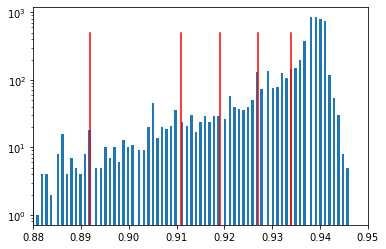

In [2]:
df = pd.read_csv('liverpool-ion-switching-publicleaderboard.csv')
df['DateTime'] = pd.to_datetime(df['SubmissionDate'], format='%Y-%m-%d %h-%M-%s', errors='ignore')


df[df['TeamName']=='cthierfelder']
score = df['Score']
plt.hist(score,bins=np.linspace(np.min(score),np.max(score),2000));
plt.yscale('log')
for s in df[df['TeamName']=='cthierfelder']['Score'].to_numpy():
    pass
    plt.plot([s,s],[0,500],color='red')
    plt.xlim(0.88,0.95)

In [16]:
df

,TeamId,TeamName,SubmissionDate,Score,DateTime
0,4458093,Adrian Brodzik,2020-02-26 22:37:11,0.047,2020-02-26 22:37:11
1,4457240,farmersrice,2020-02-26 22:39:26,0.853,2020-02-26 22:39:26
2,4457945,Youri Matiounine,2020-02-26 22:56:59,0.152,2020-02-26 22:56:59
3,4458093,Adrian Brodzik,2020-02-26 23:13:36,0.064,2020-02-26 23:13:36
4,4458373,Hasni Med Bilel,2020-02-26 23:21:34,0.905,2020-02-26 23:21:34
...,...,...,...,...,...
6462,4452221,Antonio Marin,2020-04-08 05:08:21,0.941,2020-04-08 05:08:21
6463,4534300,Aleksandr Stepa,2020-04-08 05:25:11,0.936,2020-04-08 05:25:11
6464,4447424,Gunes Evitan,2020-04-08 05:36:43,0.940,2020-04-08 05:36:43
6465,4584695,matsui,2020-04-08 05:50:40,0.941,2020-04-08 05:50:40


(0.9, 0.95)

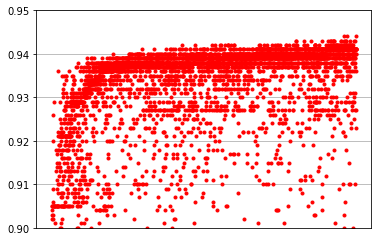

In [82]:
df2 = df[df.index>0]
fig, ax = plt.subplots()
#ax.plot_date(x=df2['DateTime'].to_numpy(),y=df2['Score'].to_numpy(), xdate=True,markersize = 5,marker='+')


ax.plot_date(df2['DateTime'],df2['Score'],'r.')
ax.xaxis.set_major_locator(mdates.DayLocator() )
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax.xaxis.set_minor_locator(mdates.DayLocator() )

ax.format_xdata = mdates.DateFormatter('%m-%d')
ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.

ax.grid(True)
ax.set_ylim(0.9,0.95)


In [29]:
datelist = pd.date_range(end = pd.datetime.today(), periods=100).tolist()
datelist

[datetime.datetime(2019, 12, 31, 14, 32, 12, 616886),
 datetime.datetime(2020, 1, 1, 14, 32, 12, 616886),
 datetime.datetime(2020, 1, 2, 14, 32, 12, 616886),
 datetime.datetime(2020, 1, 3, 14, 32, 12, 616886),
 datetime.datetime(2020, 1, 4, 14, 32, 12, 616886),
 datetime.datetime(2020, 1, 5, 14, 32, 12, 616886),
 datetime.datetime(2020, 1, 6, 14, 32, 12, 616886),
 datetime.datetime(2020, 1, 7, 14, 32, 12, 616886),
 datetime.datetime(2020, 1, 8, 14, 32, 12, 616886),
 datetime.datetime(2020, 1, 9, 14, 32, 12, 616886),
 datetime.datetime(2020, 1, 10, 14, 32, 12, 616886),
 datetime.datetime(2020, 1, 11, 14, 32, 12, 616886),
 datetime.datetime(2020, 1, 12, 14, 32, 12, 616886),
 datetime.datetime(2020, 1, 13, 14, 32, 12, 616886),
 datetime.datetime(2020, 1, 14, 14, 32, 12, 616886),
 datetime.datetime(2020, 1, 15, 14, 32, 12, 616886),
 datetime.datetime(2020, 1, 16, 14, 32, 12, 616886),
 datetime.datetime(2020, 1, 17, 14, 32, 12, 616886),
 datetime.datetime(2020, 1, 18, 14, 32, 12, 616886),
 

### Read Data

In [3]:
dfTrain =pd.read_csv('train.csv')
dfTest =pd.read_csv('test.csv')

In [4]:
RANDOM_SEED = 42
sampleReduction = 4
BATCH_SIZE = 64
EPOCHS = 5

N  = 50000

In [5]:
dfTrain['isTrain'] = True
dfTest['isTrain'] = False
dfTest['open_channels'] = np.nan

dfFull = pd.concat([dfTrain, dfTest], sort=False).reset_index(drop=True)
dfFull['isTrain'] = dfFull['isTrain'].astype('bool')
dfFull = dfFull.sort_values(by=['time']).reset_index(drop=True)

N1 = dfFull.shape[0]/N/10

dfFull['batch']         = dfFull.index.values//N
dfFull['batch_index']   = dfFull.index.values%N
dfFull['batch_slices']  = dfFull.batch.values//N1
dfFull['batch_slices2'] = dfFull.batch.map(str) + "_" + dfFull.batch_slices.map(str)

### Augment data

In [6]:
dfFull['signal_batch_min']  = dfFull.groupby('batch')['signal'].transform('min')
dfFull['signal_batch_max']  = dfFull.groupby('batch')['signal'].transform('max')
dfFull['signal_batch_std']  = dfFull.groupby('batch')['signal'].transform('std')
dfFull['signal_batch_mean'] = dfFull.groupby('batch')['signal'].transform('mean')
dfFull['signal_shift+1']    = dfFull.groupby(['batch']).shift(1)['signal']
dfFull['signal_shift-1']    = dfFull.groupby(['batch']).shift(-1)['signal']
dfFull['signal_shift+2']    = dfFull.groupby(['batch']).shift(2)['signal']
dfFull['signal_shift-2']    = dfFull.groupby(['batch']).shift(-2)['signal']

window_sizes = [1000,5000]
for window in window_sizes:
    dfFull["rolling_mean_"+ str(window)] = dfFull['signal'].rolling(window=window).mean()
    dfFull["rolling_std_" + str(window)] = dfFull['signal'].rolling(window=window).std()
    dfFull["rolling_var_" + str(window)] = dfFull['signal'].rolling(window=window).var()
    dfFull["rolling_min_" + str(window)] = dfFull['signal'].rolling(window=window).min()
    dfFull["rolling_max_" + str(window)] = dfFull['signal'].rolling(window=window).max()
    dfFull["rolling_min_max_diff_" + str(window)] = dfFull["rolling_max_" + str(window)] - dfFull["rolling_min_" + str(window)]

    a = (dfFull['signal'] - dfFull['rolling_min_' + str(window)]) / (dfFull['rolling_max_' + str(window)] - dfFull['rolling_min_' + str(window)])
    dfFull["norm_" + str(window)] = a * (np.floor(dfFull['rolling_max_' + str(window)]) - np.ceil(dfFull['rolling_min_' + str(window)]))

dfFull = dfFull.replace([np.inf, -np.inf], np.nan)    
dfFull.fillna(0, inplace=True)

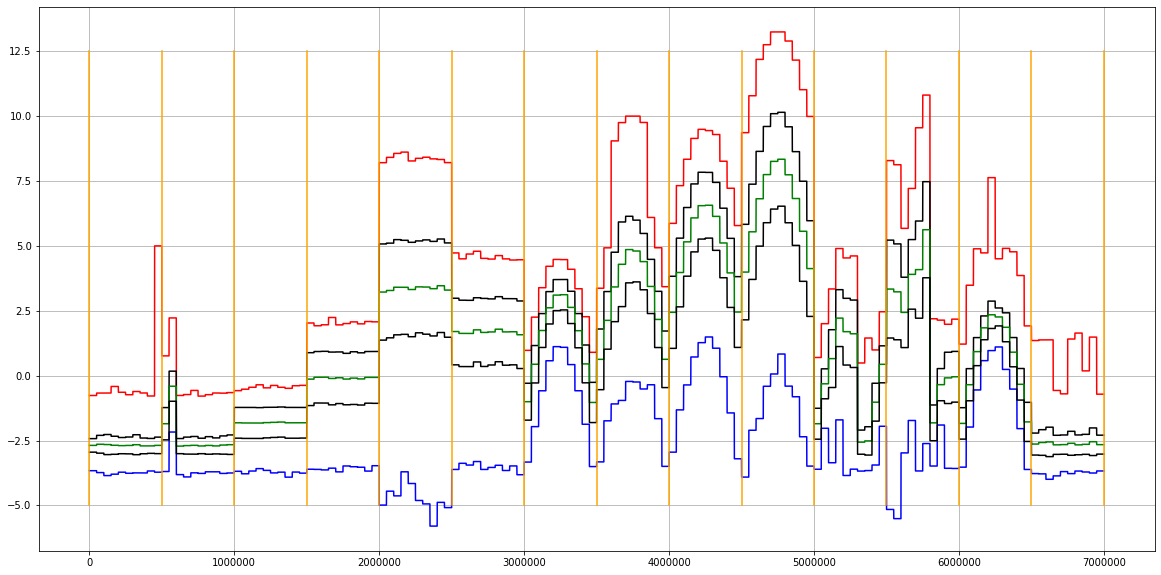

In [7]:
fig, ax = plt.subplots(figsize=(20, 10)) 
ax.plot(dfFull.signal_batch_min,color='blue')
ax.plot(dfFull.signal_batch_max,color='red')
ax.plot(dfFull.signal_batch_mean+dfFull.signal_batch_std,color='black')
ax.plot(dfFull.signal_batch_mean,color='green')
ax.plot(dfFull.signal_batch_mean-dfFull.signal_batch_std,color='black')
ax.grid(True)
for i in np.linspace(0,7000000,15):
    ax.plot([i,i],[-5,12.5],color='orange')

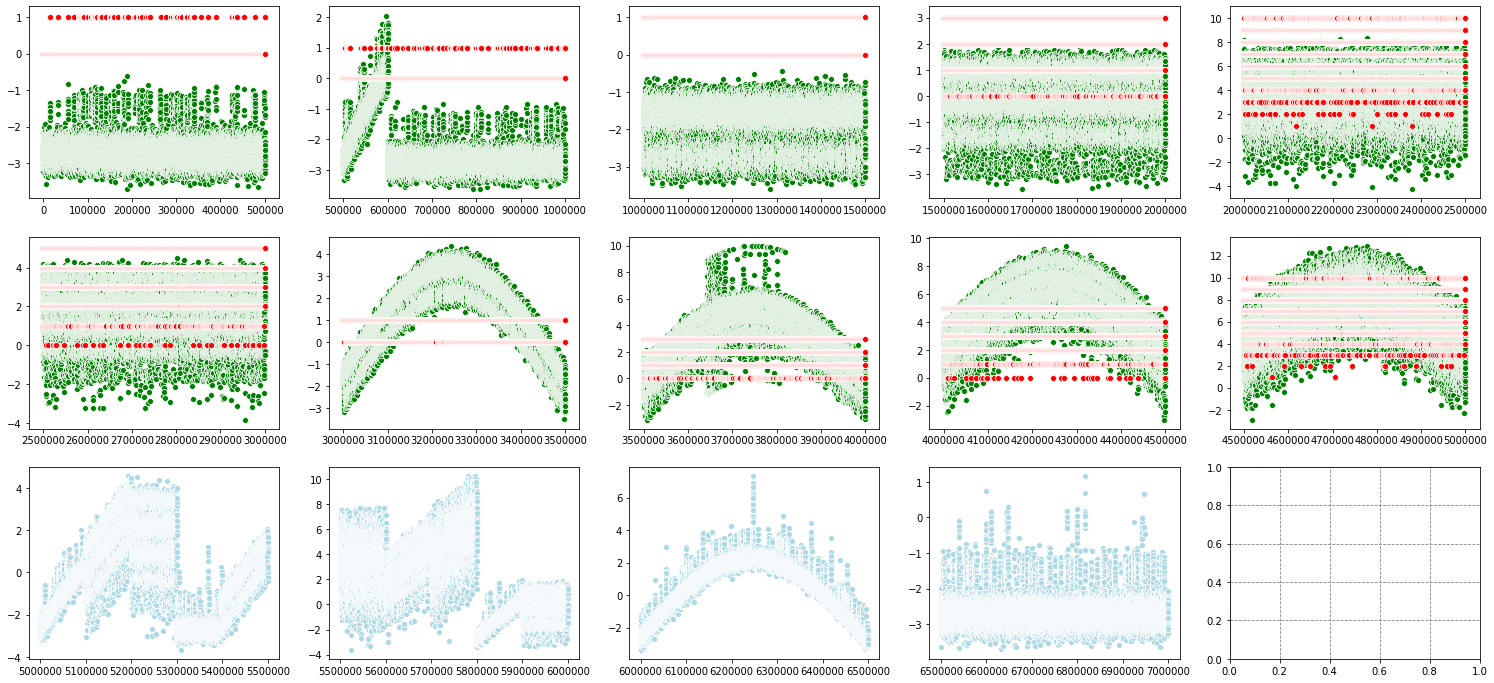

In [8]:
f, axes = plt.subplots(nrows = 3, ncols = 5, figsize = (26,12))
for i in range(10):
    sns.scatterplot(data=dfFull.iloc[500000*i:500000*(i+1)].iloc[::20].signal,hue="size", size="size",ax=axes[int(i/5), i%5],color='green')
    sns.scatterplot(data=dfFull.iloc[500000*i:500000*(i+1)].iloc[::20].open_channels,hue="size", size="size",ax=axes[int(i/5), i%5],color='red')
    plt.grid(True,which="both",ls="--",c='gray')  
    
for i in [10,11,12,13]:
    sns.scatterplot(data=dfFull.iloc[500000*i:500000*(i+1)].iloc[::20].signal,hue="size", size="size",ax=axes[int(i/5), i%5],color='lightblue')
    plt.grid(True,which="both",ls="--",c='gray')  

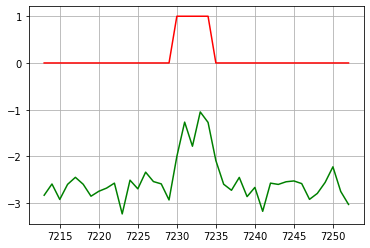

In [9]:
point =7233
sns.lineplot(data=dfFull.iloc[point-20:point+20].signal,hue="size", size="size",color='green')
sns.lineplot(data=dfFull.iloc[point-20:point+20].open_channels,hue="size", size="size",color='red')
plt.grid(True)


In [9]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())
    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def LSTM_model(input_shape, units = 32, max_channels = 11, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units, input_shape=(input_shape[1], input_shape[2]), return_sequences=True))
    model.add(LSTM(units, return_sequences=True))
    model.add(LSTM(units, return_sequences=True))
    model.add(LSTM(units, return_sequences=True))
    model.add(LSTM(units, return_sequences=True))    #extra
    model.add(LSTM(units))
    model.add(Dense(units))
    model.add(Dense(max_channels, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc', f1])
    #model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc', f1_score])
    return model

LSTM_FEATURES = ['signal', 'signal_batch_mean', 'batch_index', 
                 'rolling_max_5000', 'rolling_min_max_diff_5000',
                 'norm_1000', 'norm_5000',
                 'signal_shift-1', 'signal_shift+1']

train_df = dfFull.query('isTrain').copy()
test_df  = dfFull.query('not isTrain').copy()
train_df['open_channels'] = train_df['open_channels'].astype(int)

X_all_train = train_df[LSTM_FEATURES]
X_all_test  = test_df[LSTM_FEATURES]
y_all_train = train_df['open_channels'].values

## reduce amount of data to speed things up
X_train = X_all_train[::sampleReduction]
y_train = y_all_train[::sampleReduction]
X_test = X_all_test[::sampleReduction] ## this is just for display purposes

#del full
#del train_df
#del test_df
#gc.collect()

X = X_train[LSTM_FEATURES]
y = y_train

## reshape for LSTM
X = X.values.reshape(-1,len(LSTM_FEATURES),1)
## using categorical_crossentropy
yy = to_categorical(y, num_classes=11)

train_idx, val_idx = train_test_split(np.arange(X.shape[0]), random_state = RANDOM_SEED, test_size = 0.2)

X_t = X[train_idx] 
y_t = yy[train_idx] 
X_v = X[val_idx]
y_v = yy[val_idx]

es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.000001, verbose=1)

adam = Adam(0.01)

print('INPUT SHAPE: ',X_t.shape)
model = LSTM_model(X_t.shape, optimizer=adam)
history = model.fit( X_t, y_t, validation_data=(X_v, y_v), callbacks=[es,lr],
                    batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, 
                    shuffle=False, workers=8, use_multiprocessing=True )

INPUT SHAPE:  (1000000, 9, 1)
Train on 1000000 samples, validate on 250000 samples
Epoch 1/5
1000000/1000000 [==============================] - 51255s 51ms/sample - loss: 0.2816 - acc: 0.8957 - f1: 0.7375 - val_loss: 0.1789 - val_acc: 0.9330 - val_f1: 0.7801
Epoch 2/5
  77504/1000000 [=>............................] - ETA: 4:14 - loss: 0.1675 - acc: 0.9377 - f1: 0.7972WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,f1


KeyboardInterrupt: 

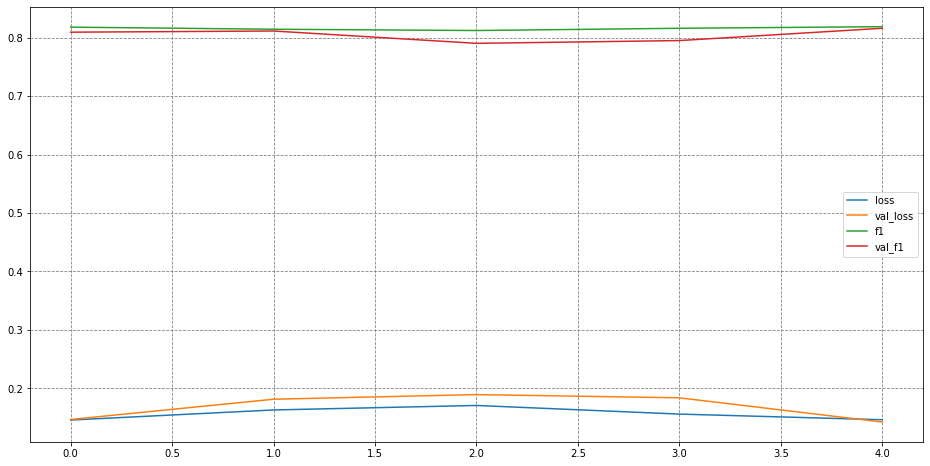

In [68]:
fig, ax1 = plt.subplots(nrows = 1, ncols = 1, figsize = (16,8))
sns.lineplot(data=np.asarray(history.history['loss']), label='loss', ax=ax1)
sns.lineplot(data=np.asarray(history.history['val_loss']), label='val_loss', ax=ax1)
sns.lineplot(data=np.asarray(history.history['f1']), label='f1', ax=ax1)
sns.lineplot(data=np.asarray(history.history['val_f1']), label='val_f1', ax=ax1)
plt.grid(True,which="both",ls="--",c='gray')

In [69]:
y_pred = np.argmax(model.predict(X_v), axis=1).reshape(-1)
yhat = y[val_idx]

#print("SCORE_oldmetric: ", cohen_kappa_score(yhat, y_pred, weights="quadratic"))
print("SCORE_newmetric: ", f1_score(yhat, y_pred, labels=range(11), average="macro"))

SCORE_newmetric:  0.9021557280708016


In [ ]:
#SCORE_newmetric:  0.8430717044004116   (sampling=100)
#SCORE_newmetric:  0.8430293596793188   (sampling=100, without +/-1 shifts)
#SCORE_newmetric:  0.838977399020315    (sampling=100, with +/-1 shifts)
#SCORE_newmetric:  0.8590825017181634   (sampling=100, +1=6 LSTMs)
#SCORE_newmetric:  0.8984321353001995   (sampling = 4, +1=6 LSTMs 5epochs)
#SCORE_newmetric:  0.9021557280708016   (sampling = 4, +1=6 LSTMs 5+5epochs)

In [71]:
y_pred = np.argmax(model.predict(X_all_test[LSTM_FEATURES].values.reshape(-1,len(LSTM_FEATURES), 1)), axis=1).reshape(-1)

In [75]:
sub = pd.read_csv("sample_submission.csv", dtype={'time':str})
sub.open_channels = np.array(np.round(y_pred,0), np.int)
sub.to_csv("ion_CT06_10epochs.csv",index=False)

In [74]:
y_pred.shape

(2000000,)

In [139]:
import numpy as np
from sklearn.decomposition import PCA
n=300
#X = np.array([np.random.normal(loc=0,scale=1.0,size=n),np.random.normal(loc=0,scale=3.0,size=n)]).T
X = np.random.multivariate_normal([0,0], [[1,2],[2,8]], 300)
pca = PCA(n_components=2)
pca.fit(X)
PCA(n_components=2)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
print(pca.n_components_)
print(pca.components_)

[0.94895898 0.05104102]
[50.7364002  11.76672466]
2
[[ 0.28131963  0.95961412]
 [ 0.95961412 -0.28131963]]


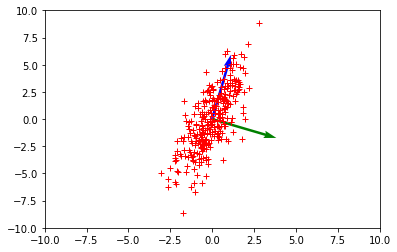

In [140]:
plt.plot(*X.T,'r+')
origin = [0],[0]
plt.quiver(*origin, pca.components_[:,0], pca.components_[:,1], color=['b','g'], scale=5)
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.show()

In [119]:
X

array([[-1.93037289,  0.50528154,  0.17714197, ...,  0.45239981,
        -0.38852435,  0.82575825],
       [-1.63837696,  0.75057309,  0.93002705, ...,  0.29596732,
        -0.08441685,  0.59448042]])